In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from skimage.transform import resize
import tensorflow.keras.backend as K
import datetime
import json
import matplotlib.pyplot as plt

/Users/shivshankar/Desktop/Thesis MSCSK/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
import tensorflow as tf
print(tf.__version__)


2.13.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# -------------------------------
# 2. Define Custom Metrics
# -------------------------------
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculates the Dice Coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    """
    Calculates the Intersection over Union (IoU) metric.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [5]:
# Define the data directory (adjust this path if necessary)
data_dir = 'brats2020/content/data'

# Get list of .h5 files
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]

# Ensure that there are .h5 files in the directory
if not h5_files:
    raise FileNotFoundError(f"No .h5 files found in the directory: {data_dir}")

# Split into training and validation sets
train_files, val_files = train_test_split(h5_files, test_size=0.2, random_state=42)

print(f"Total samples: {len(h5_files)}")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

Total samples: 57195
Training samples: 45756
Validation samples: 11439


In [6]:
# Parameters
batch_size = 8  # Adjust based on GPU memory
image_dim = (128, 128)  # Adjust based on your image dimensions


In [7]:
# -------------------------------
# 5. Define the Data Generator
# -------------------------------
class DataGenerator(Sequence):
    def __init__(self, h5_files, data_dir, batch_size=16, dim=(128, 128), shuffle=True):
        self.h5_files = h5_files
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.h5_files))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.h5_files) / self.batch_size))
        
    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        h5_batch = [self.h5_files[k] for k in batch_indexes]
        X, y = self.__data_generation(h5_batch)
        return X, y
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __data_generation(self, h5_batch):
        # Initialize arrays
        X = np.empty((self.batch_size, *self.dim, 4), dtype='float32')  # 4 channels
        y = np.empty((self.batch_size, *self.dim, 1), dtype='float32')  # Single-channel masks
            
        for i, h5_file in enumerate(h5_batch):
            file_path = os.path.join(self.data_dir, h5_file)
            with h5py.File(file_path, 'r') as hf:
                # Check for the correct keys
                if 'image' in hf.keys() and 'mask' in hf.keys():
                    image = hf['image'][:]  # Expected shape: (H, W, 4)
                    mask = hf['mask'][:]    # Expected shape: (H, W) or (H, W, C)
                else:
                    raise KeyError(f"Unexpected keys in {h5_file}: {list(hf.keys())}")

                # If mask has multiple channels, convert to single-channel
                if mask.ndim > 2:
                    mask = np.mean(mask, axis=-1)  # Example: Convert RGB to grayscale

                # Resize images if necessary
                if image.shape[:2] != self.dim:
                    image = resize(
                        image, 
                        (*self.dim, image.shape[2]), 
                        preserve_range=True, 
                        anti_aliasing=True
                    )
                
                if mask.shape != self.dim:
                    # Use nearest-neighbor interpolation for masks to preserve labels
                    mask = resize(
                        mask, 
                        self.dim, 
                        preserve_range=True, 
                        order=0, 
                        anti_aliasing=False
                    )

                # Normalize the image
                image_max = np.max(image)
                if image_max > 0:
                    image = image.astype('float32') / image_max
                else:
                    image = image.astype('float32')

                # Normalize the mask
                mask_max = np.max(mask)
                if mask_max > 0:
                    mask = mask.astype('float32') / mask_max
                else:
                    mask = mask.astype('float32')  # All zeros

                # Assign to batch arrays
                X[i] = image  # Shape: (128, 128, 4)
                y[i] = np.expand_dims(mask, axis=-1)  # Shape: (128, 128, 1)
            
        return X, y

In [8]:
# 6. Instantiate Data Generators
# -------------------------------
training_generator = DataGenerator(train_files, data_dir, batch_size=batch_size, dim=image_dim, shuffle=True)
validation_generator = DataGenerator(val_files, data_dir, batch_size=batch_size, dim=image_dim, shuffle=False)


In [9]:
# 8. Define Callbacks
# -------------------------------
# Create a timestamp for the logs
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# TensorBoard callback for visualization
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# EarlyStopping callback with multiple metric monitoring
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

# ModelCheckpoint callback to save the best model with '.keras' extension
model_checkpoint = ModelCheckpoint(
    'model-unet.best.h5',  # Changed from '.h5' to '.keras'
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# Combine all callbacks
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback
]


You should consider upgrading via the '/Users/shivshankar/Desktop/Thesis MSCSK/venv/bin/python3 -m pip install --upgrade pip' command.


In [11]:
import pennylane as qml
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.models import Model
import numpy as np

# Quantum Circuit
n_qubits = 4  
n_layers = 2  
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs):
    """Quantum circuit processing inputs"""
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    for _ in range(n_layers):
        qml.templates.BasicEntanglerLayers(weights=np.random.randn(n_layers, n_qubits), wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Custom Keras Quantum Layer
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim=n_qubits, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.dense = Dense(n_qubits, activation="tanh")  

    def call(self, inputs):
        reduced_inputs = self.dense(inputs)  # Ensuring the correct input shape
        outputs = tf.vectorized_map(lambda x: quantum_circuit(x), reduced_inputs)
        return tf.reshape(outputs, (-1, self.output_dim))  # Ensuring correct batch output shape

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

# Function to Modify VGG16 for 4-channel Input
def get_vgg16_encoder(input_shape=(128, 128, 4)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv1")(inputs)
    
    # Load pretrained VGG16 with a 3-channel input to extract weights
    vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    
    for i in range(2, len(vgg16.layers)):  # Skip input and first Conv2D layer
        x = vgg16.layers[i](x)

    return Model(inputs, x, name="VGG16_Modified")

# U-Net Model with VGG16 Encoder + Quantum Circuit
def build_quantum_unet(input_shape=(128, 128, 4)):
    inputs = Input(shape=input_shape)

    # VGG16 Encoder (Pretrained, Modified)
    base_model = get_vgg16_encoder(input_shape)
    encoder_output = base_model(inputs)  # Last convolutional layer (4x4x512)

    # Quantum Layer at Bottleneck
    q_input = GlobalAveragePooling2D()(encoder_output)  # Reduce spatial dims to (512,)
    q_output = QuantumLayer()(q_input)  # Quantum Processing (4,)

    # Reshape quantum output to match CNN feature maps
    # Ensure quantum output has correct dimensions before reshaping
    q_feature_map = Reshape((1, 1, n_qubits))(q_output)  # Output shape: (batch_size, 1, 1, 4)
    q_feature_map = Conv2D(256, (1, 1), activation="relu", padding="same")(q_feature_map)  # Match channels
    q_feature_map = UpSampling2D((4, 4))(q_feature_map)  # Resize to (4x4,256)

    # Decoder (U-Net)
    x = UpSampling2D((2, 2))(encoder_output)  # Upsample to (8x8,512)
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    # Ensure shape match before concatenation
    q_feature_map = UpSampling2D((2, 2))(q_feature_map)  # Resize to (8x8,256)
    
    x = Concatenate()([x, q_feature_map])  # Now shapes match (8x8,512)

    x = UpSampling2D((2, 2))(x)  # Upsample to (16x16)
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)  # Upsample to (32x32)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)  # Upsample to (64x64)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    x = UpSampling2D((2, 2))(x)  # Upsample to (128x128)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

# Build and check the model
model = build_quantum_unet()
model.summary()


2025-03-20 12:41:24.919400: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-20 12:41:24.919485: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-20 12:41:24.919522: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-20 12:41:24.920236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-20 12:41:24.920649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Plea

In [12]:
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, iou_metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 VGG16_Modified (Functional  (None, 4, 4, 512)            1471526   ['input_1[0][0]']             
 )                                                        4                                       
                                                                                                  
 global_average_pooling2d (  (None, 512)                  0         ['VGG16_Modified[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                              

In [13]:
epochs = 1 # You can adjust this based on your requirements

try:
    results = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1  # Set to 1 for progress bar, 2 for one line per epoch, 0 for silent
    )
except Exception as e:
    print(f"An error occurred during training: {e}")

2025-03-20 12:41:55.654703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5719/5719 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9944 - dice_coefficient: 0.5781 - iou_metric: 0.4295      

2025-03-20 13:05:41.108097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.01034, saving model to model-unet.best.h5


/Users/shivshankar/Desktop/Thesis MSCSK/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5719/5719 [==============================] - 1596s 278ms/step - loss: 0.0153 - accuracy: 0.9944 - dice_coefficient: 0.5781 - iou_metric: 0.4295 - val_loss: 0.0103 - val_accuracy: 0.9960 - val_dice_coefficient: 0.6839 - val_iou_metric: 0.5375


In [14]:
model.save('final_model_unet.keras')
print("Model training complete and saved as 'final_model_unet.keras'.")


Model training complete and saved as 'final_model_unet.keras'.


In [15]:
with open('training_history.json', 'w') as f:
    json.dump(results.history, f)
print("Training history saved as 'training_history.json'.")

# -------------------------------
# 12. Plot Training History
# -------------------------------
def plot_training_history(history, metrics=['loss', 'accuracy', 'dice_coefficient', 'iou_metric']):
    """
    Plots training and validation metrics over epochs.
    """
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        plt.plot(history[metric], label=f'Training {metric}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{metric}_plot.png')
        plt.close()
        print(f"{metric.capitalize()} plot saved as '{metric}_plot.png'.")

# Plot and save the training history
plot_training_history(results.history)

Training history saved as 'training_history.json'.
Loss plot saved as 'loss_plot.png'.
Accuracy plot saved as 'accuracy_plot.png'.
Dice_coefficient plot saved as 'dice_coefficient_plot.png'.
Iou_metric plot saved as 'iou_metric_plot.png'.


In [16]:
# -------------------------------
# 14. Visualize Results
# -------------------------------
def visualize_predictions(generator, model, num_samples=5):
    """
    Visualizes predictions of the model on a few samples.
    """
    samples_visualized = 0
    for X_batch, y_true_batch in generator:
        # Predict the batch
        y_pred_batch = model.predict(X_batch)
        
        for i in range(len(X_batch)):
            if samples_visualized >= num_samples:
                return  # Stop after visualizing the requested number of samples
            
            input_image = X_batch[i]
            true_mask = y_true_batch[i].squeeze()  # Remove single channel
            pred_mask = y_pred_batch[i].squeeze()  # Remove single channel
            
            # Plot input image, true mask, and predicted mask
            plt.figure(figsize=(12, 6))
            
            # Original Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(input_image[..., 0], cmap='gray')  # Show only one channel
            plt.title('Input Image (Channel 0)')
            plt.axis('off')
            
            # True Mask
            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            
            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
            
            # Save or show the plot
            plt.savefig(f'sample_visualization_{samples_visualized + 1}.png')
            plt.close()
            
            print(f"Visualization for sample {samples_visualized + 1} saved as 'sample_visualization_{samples_visualized + 1}.png'")
            samples_visualized += 1

# Visualize predictions on the validation set
print("Visualizing predictions on the validation set...")
visualize_predictions(validation_generator, model, num_samples=5)

Visualizing predictions on the validation set...


2025-03-20 13:39:10.259312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step
Visualization for sample 1 saved as 'sample_visualization_1.png'
Visualization for sample 2 saved as 'sample_visualization_2.png'
Visualization for sample 3 saved as 'sample_visualization_3.png'
Visualization for sample 4 saved as 'sample_visualization_4.png'
Visualization for sample 5 saved as 'sample_visualization_5.png'


In [17]:
from tensorflow.keras.models import load_model

# Define the file path (adjust if necessary)
model_path = 'final_model_unet.keras'

# Load the model with custom objects
model = load_model(model_path, custom_objects={
    'dice_coefficient': 0.8234,
    'iou_metric': 0.7008
})

print("Model loaded successfully!")

TypeError: 'str' object is not callable

In [18]:
def preprocess_image(file_path, image_dim=(128, 128)):
    """
    Loads and preprocesses an image and its corresponding mask from an h5 file.
    """
    with h5py.File(file_path, 'r') as hf:
        # Check for 'image' and 'mask' keys
        if 'image' in hf.keys() and 'mask' in hf.keys():
            image = hf['image'][:]  # Shape: (H, W, 4)
            mask = hf['mask'][:]    # Shape: (H, W)
        else:
            raise KeyError(f"Unexpected keys in {file_path}: {list(hf.keys())}")

        # Print mask statistics for debugging
        print(f"Mask stats for {file_path}: min={mask.min()}, max={mask.max()}, mean={mask.mean()}")

        # Resize the image and mask to match the model's input dimensions
        if image.shape[:2] != image_dim:
            image = resize(image, (*image_dim, image.shape[2]), preserve_range=True, anti_aliasing=True)
        if mask.shape[:2] != image_dim:
            mask = resize(mask, image_dim, preserve_range=True, order=0, anti_aliasing=False)

        # Normalize the image
        image_max = np.max(image)
        if image_max > 0:
            image = image.astype('float32') / image_max

        # Normalize the mask to range [0, 1] for visualization
        mask = np.expand_dims((mask - mask.min()) / (mask.max() - mask.min() + 1e-8), axis=-1)

    return image, mask


Mask stats for brats2020/content/data/volume_106_slice_100.h5: min=0, max=1, mean=0.014253472222222223
1/1 [==============================] - 0s 258ms/step


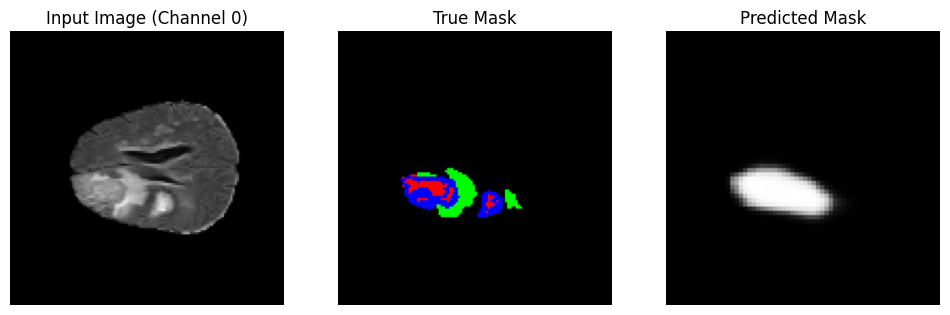

In [19]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# -------------------------------
# Visualize Predictions
# -------------------------------
def predict_and_visualize(file_paths, model, image_dim=(128, 128)):
    """
    Loads and preprocesses images from file paths, predicts their outputs, and visualizes results.
    """
    for i, file_path in enumerate(file_paths):
        # Load and preprocess the image and mask
        image, true_mask = preprocess_image(file_path, image_dim)

        # Predict the mask using the model
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Add batch dimension, then remove it

        # Visualize the input image, true mask, and predicted mask
        plt.figure(figsize=(12, 6))

        # Original Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(image[..., 0], cmap='gray')  # Display the first channel
        plt.title('Input Image (Channel 0)')
        plt.axis('off')

        # True Mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')  # Remove the channel dimension for display
        plt.title('True Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')  # Remove the channel dimension for display
        plt.title('Predicted Mask')
        plt.axis('off')

        # Show the plot directly
        plt.show()

# -------------------------------
# Specify the File Paths
# -------------------------------
data_dir = 'brats2020/content/data'
files_to_predict = [
    "brats2020/content/data/volume_106_slice_100.h5"
    
]

# -------------------------------
# Predict and Visualize
# -------------------------------
predict_and_visualize(files_to_predict, model)

In [40]:
!pip freeze > requirements.txt